In [1]:
import numpy as np 
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import dataloader as da
import matplotlib.pyplot as plt

# EEG Network (EEGNet)

In [2]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 120

        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = (1, 51), stride = (1, 1), padding = (0, 25), bias = False)
        self.batchnorm1 = nn.BatchNorm2d(16, eps = 1e-03, momentum=0.1, affine= True, track_running_stats=True)
        
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size = (2, 1), stride = (1, 1), groups = 16, bias = False)
        self.batchnorm2 = nn.BatchNorm2d(32, eps = 1e-03, momentum = 0.1, affine = True, track_running_stats = True)
        self.pooling2 = nn.AvgPool2d(kernel_size=(1, 4), stride = (1, 4), padding = 0)
        
        # Layer 3
        self.conv3 = nn.Conv2d(32, 32, kernel_size = (1, 15), stride = (1, 1), padding = (0, 7), bias = False)
        self.batchnorm3 = nn.BatchNorm2d(32, eps = 1e-03, momentum = 0.1, affine = True, track_running_stats = True)
        self.pooling3 = nn.AvgPool2d(kernel_size = (1, 8), stride = (1, 8), padding = 0)
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(in_features = 736, out_features = 1, bias = True)
        
    def forward(self, x, params):

        # Layer 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
       
        # Layer 2
        x = self.conv2(x)
        x = self.batchnorm2(x)
        if(params == 'elu'):x = F.elu(x, 1.0)
        elif(params == 'relu'):x = F.relu(x)
        elif(params == 'leaky_relu'):x = F.leaky_relu(x)
        else:print("EEG_Layer 2 error")
        x = self.pooling2(x)
        x = F.dropout(x, 0.25)
       
        # Layer 3
        x = self.conv3(x)
        x = self.batchnorm3(x)
        if(params == 'elu'):x = F.elu(x, 1.0)
        elif(params == 'relu'):x = F.relu(x)
        elif(params == 'leaky_relu'):x = F.leaky_relu(x)
        else:print("EEG_Layer 2 error")
        x = self.pooling3(x)
        x = F.dropout(x, 0.25)

        
        # FC Layer
        x = x.view(-1, 736)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        
        return x

# Deep Convolution Network (DCNNet)

In [3]:
class DCNNet(nn.Module):
    def __init__(self):
        super(DCNNet, self).__init__()
        self.T = 120

        # Layer 1
        self.conv1 = nn.Conv2d(1, 25, kernel_size = (1, 5))
        self.conv2 = nn.Conv2d(25, 25, kernel_size = (2, 1))
        self.batchnorm1 = nn.BatchNorm2d(25, eps = 1e-03, momentum=0.1)
        self.pooling1 = nn.MaxPool2d(kernel_size=(1, 2))
        
        # Layer 2
        self.conv3 = nn.Conv2d(25, 50, kernel_size = (1, 5))
        self.batchnorm2 = nn.BatchNorm2d(50, eps = 1e-03, momentum=0.1)
        self.pooling2 = nn.MaxPool2d(kernel_size=(1, 2))
        
        # Layer 3
        self.conv4 = nn.Conv2d(50, 100, kernel_size = (1, 5))
        self.batchnorm3 = nn.BatchNorm2d(100, eps = 1e-03, momentum=0.1)
        self.pooling3 = nn.MaxPool2d(kernel_size=(1, 2))        
        
        # Layer 4
        self.conv5 = nn.Conv2d(100, 200, kernel_size = (1, 5))        
        self.batchnorm4 = nn.BatchNorm2d(200, eps = 1e-03, momentum=0.1)
        self.pooling4 = nn.MaxPool2d(kernel_size=(1, 2))             
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(in_features = 8600, out_features = 1, bias = True)
        
    def forward(self, x, params):

        # Layer 1
        x = self.conv1(x)
        x = self.conv2(x)        
        x = self.batchnorm1(x)
        if(params == 'elu'):x = F.elu(x)
        elif(params == 'relu'):x = F.relu(x)
        elif(params == 'leaky_relu'):x = F.leaky_relu(x)
        else:print("DCN_Layer 1 error")
        x = self.pooling1(x)
        x = F.dropout(x, 0.5)
        
        # Layer 2
        x = self.conv3(x)
        x = self.batchnorm2(x)
        if(params == 'elu'):x = F.elu(x)
        elif(params == 'relu'):x = F.relu(x)
        elif(params == 'leaky_relu'):x = F.leaky_relu(x)
        else:print("DCN_Layer 2 error")
        x = self.pooling2(x)
        x = F.dropout(x, 0.5)
        
        # Layer 3
        x = self.conv4(x)
        x = self.batchnorm3(x)
        if(params == 'elu'):x = F.elu(x)
        elif(params == 'relu'):x = F.relu(x)
        elif(params == 'leaky_relu'):x = F.leaky_relu(x)
        else:print("DCN_Layer 3 error")
        x = self.pooling3(x)      
        x = F.dropout(x, 0.5)
        
        # Layer 4
        x = self.conv5(x)
        x = self.batchnorm4(x)
        if(params == 'elu'):x = F.elu(x)
        elif(params == 'relu'):x = F.relu(x)
        elif(params == 'leaky_relu'):x = F.leaky_relu(x)
        else:print("DCN_Layer 4 error")
        x = self.pooling4(x)      
        x = F.dropout(x, 0.5)

        # FC Layer
        x = x.view(-1, 8600)
        x = self.fc1(x)
        x = torch.sigmoid(x)

        return x

# Data Raeder

In [4]:
X_train, y_train, X_test, y_test = da.read_bci_data()

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


# Compare Plot

In [5]:
def compare_plot(all_train_pred, all_test_pred, net_name):
    sub_epoch = range(epochs)
    plt.figure(figsize = (15, 10))
    plt.rcParams.update({'font.size':22, 'legend.loc':'lower right'})
    plt.title(f"Activation function comparison({net_name})", pad = 30)
    
    for i in range(int(len(all_train_pred) / epochs)):
        start = i*epochs
        end = (i+1)*epochs
        plt.plot(sub_epoch, all_train_pred[start:end], label = act_model[i] + "_train")
        plt.plot(sub_epoch, all_test_pred[start:end], label = act_model[i] + "_test")
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy(%)")
    plt.legend()
    plt.savefig(net_name + "_comparison.png")
    plt.show()
    plt.close()

# Global Variable (Parameters)

In [6]:
epochs = 500
batch_size = 90
batch_list = [90, 60, 30]
criterion = nn.BCELoss()

net_structure = ['EEGNet', 'DCNNet']
net_name = ""
act_model = ['elu', 'relu', 'leaky_relu']
params = ""
epoch_temp = 0

train_output = []
train_acc = []
train_loss = []
all_train_pred = []

test_output = []
test_acc = []
all_test_pred = []
total_pred = [-1,"", ""]

# Train and Test

EEGNet - elu start!
EEGNet - elu :  100 finished Max train_accuracy  94.8148 % Max test_accuracy   83.5185 % batch_size  90
EEGNet - elu :  200 finished Max train_accuracy  97.7778 % Max test_accuracy   84.2593 % batch_size  60
EEGNet - elu :  300 finished Max train_accuracy  99.4444 % Max test_accuracy   84.2593 % batch_size  60
EEGNet - elu :  400 finished Max train_accuracy  99.8148 % Max test_accuracy   84.6296 % batch_size  30
Total Epoch:  500
Net:  EEGNet - elu
Max train_accuracy  99.9074 %
Max test_accuracy   84.6296 %
min train_loss      0.2849990427


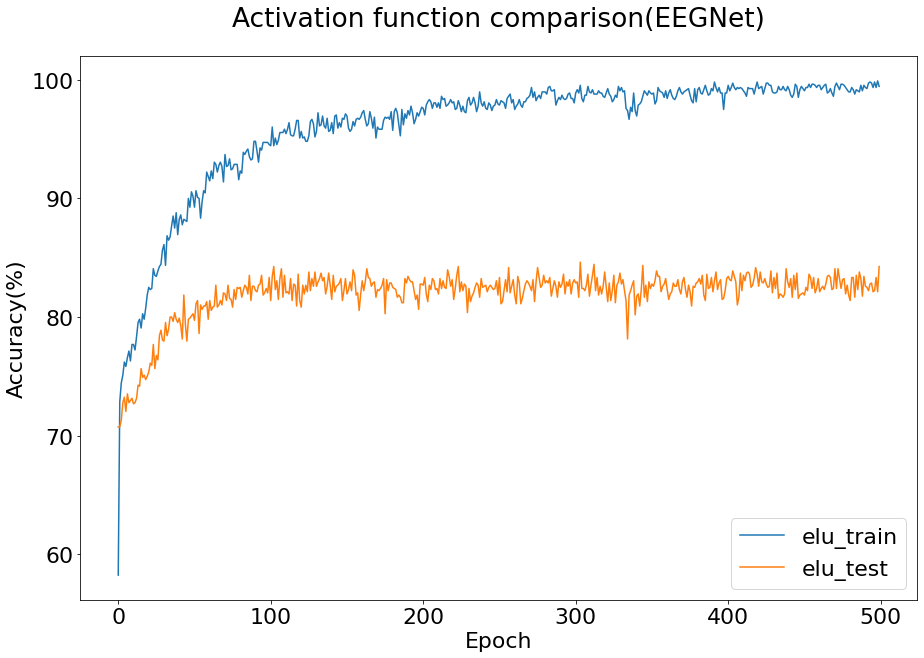

----------------------------------------------------------
EEGNet - relu start!
EEGNet - relu :  100 finished Max train_accuracy  97.3148 % Max test_accuracy   84.3519 % batch_size  90
EEGNet - relu :  200 finished Max train_accuracy  98.9815 % Max test_accuracy   85.0000 % batch_size  60
EEGNet - relu :  300 finished Max train_accuracy  99.6296 % Max test_accuracy   85.4630 % batch_size  60
EEGNet - relu :  400 finished Max train_accuracy  99.7222 % Max test_accuracy   86.1111 % batch_size  30
Total Epoch:  500
Net:  EEGNet - relu
Max train_accuracy  99.8148 %
Max test_accuracy   86.1111 %
min train_loss      0.3695021868


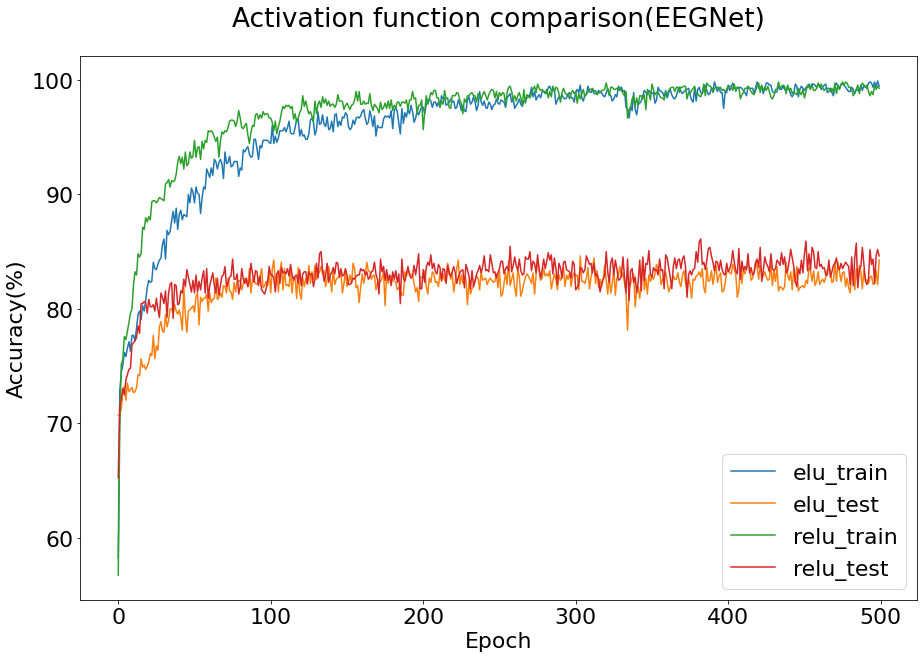

----------------------------------------------------------
EEGNet - leaky_relu start!
EEGNet - leaky_relu :  100 finished Max train_accuracy  97.3148 % Max test_accuracy   85.0000 % batch_size  90
EEGNet - leaky_relu :  200 finished Max train_accuracy  98.9815 % Max test_accuracy   85.6481 % batch_size  60
EEGNet - leaky_relu :  300 finished Max train_accuracy  99.5370 % Max test_accuracy   85.8333 % batch_size  60
EEGNet - leaky_relu :  400 finished Max train_accuracy  99.8148 % Max test_accuracy   85.8333 % batch_size  30
Total Epoch:  500
Net:  EEGNet - leaky_relu
Max train_accuracy  99.9074 %
Max test_accuracy   85.8333 %
min train_loss      0.3785021007


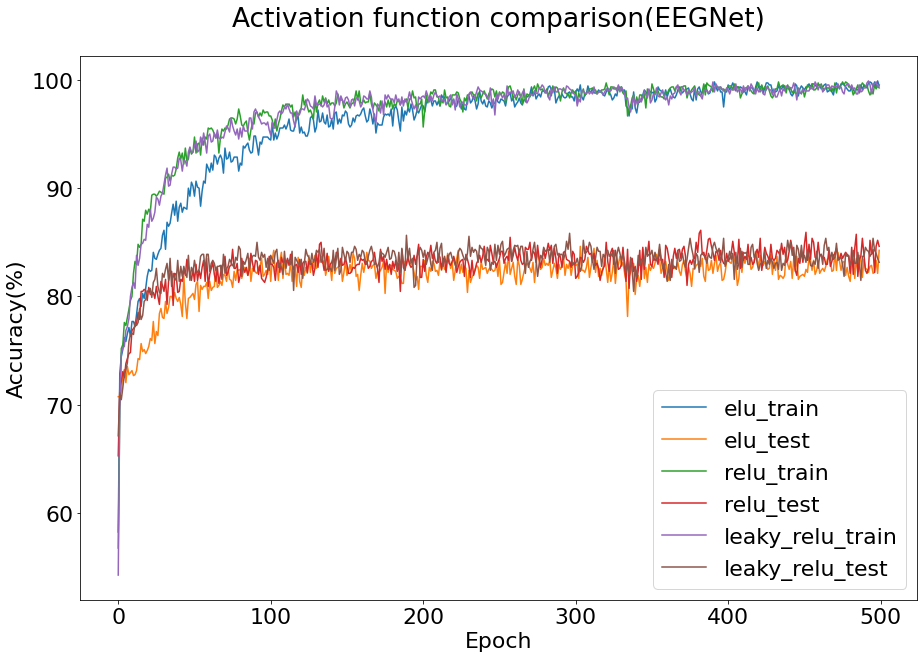

----------------------------------------------------------
DCNNet - elu start!
DCNNet - elu :  100 finished Max train_accuracy  92.5926 % Max test_accuracy   79.0741 % batch_size  90
DCNNet - elu :  200 finished Max train_accuracy  97.3148 % Max test_accuracy   80.8333 % batch_size  60
DCNNet - elu :  300 finished Max train_accuracy  98.7963 % Max test_accuracy   80.8333 % batch_size  60
DCNNet - elu :  400 finished Max train_accuracy  98.8889 % Max test_accuracy   80.8333 % batch_size  30
Total Epoch:  500
Net:  DCNNet - elu
Max train_accuracy  99.0741 %
Max test_accuracy   80.8333 %
min train_loss      0.5407117009


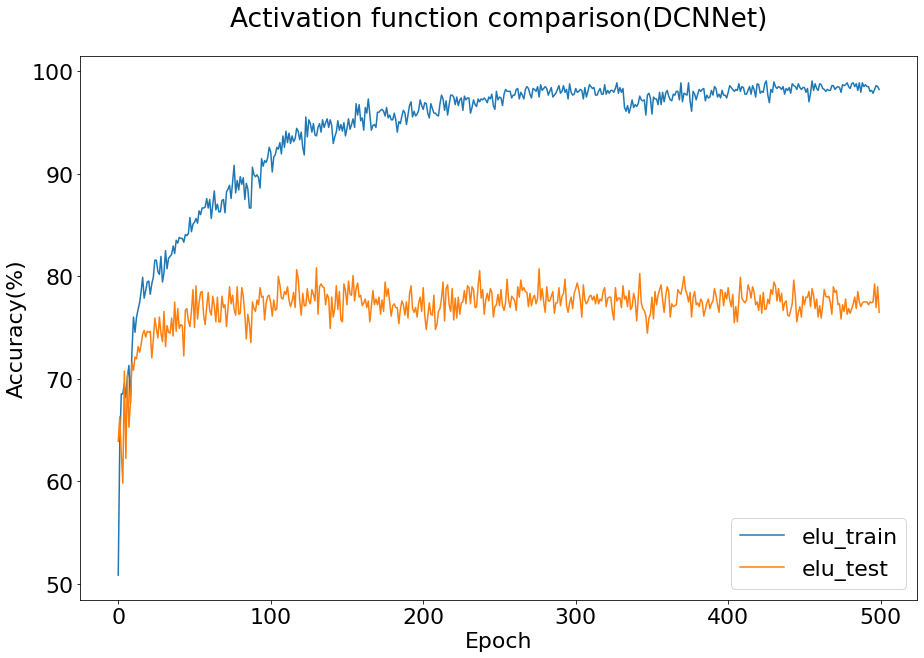

----------------------------------------------------------
DCNNet - relu start!
DCNNet - relu :  100 finished Max train_accuracy  89.2593 % Max test_accuracy   79.5370 % batch_size  90
DCNNet - relu :  200 finished Max train_accuracy  95.7407 % Max test_accuracy   80.5556 % batch_size  60
DCNNet - relu :  300 finished Max train_accuracy  97.5000 % Max test_accuracy   80.5556 % batch_size  60
DCNNet - relu :  400 finished Max train_accuracy  97.7778 % Max test_accuracy   81.5741 % batch_size  30
Total Epoch:  500
Net:  DCNNet - relu
Max train_accuracy  98.6111 %
Max test_accuracy   81.5741 %
min train_loss      1.1866730452


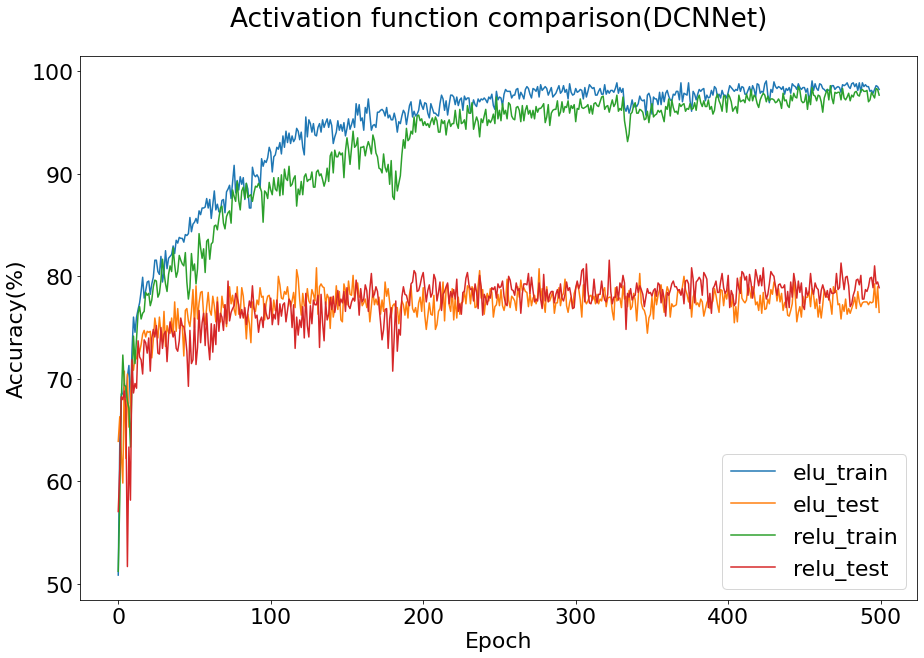

----------------------------------------------------------
DCNNet - leaky_relu start!
DCNNet - leaky_relu :  100 finished Max train_accuracy  90.1852 % Max test_accuracy   78.6111 % batch_size  90
DCNNet - leaky_relu :  200 finished Max train_accuracy  95.6481 % Max test_accuracy   79.8148 % batch_size  60
DCNNet - leaky_relu :  300 finished Max train_accuracy  97.4074 % Max test_accuracy   79.8148 % batch_size  60
DCNNet - leaky_relu :  400 finished Max train_accuracy  98.0556 % Max test_accuracy   79.8148 % batch_size  30
Total Epoch:  500
Net:  DCNNet - leaky_relu
Max train_accuracy  99.1667 %
Max test_accuracy   79.8148 %
min train_loss      1.1931555271


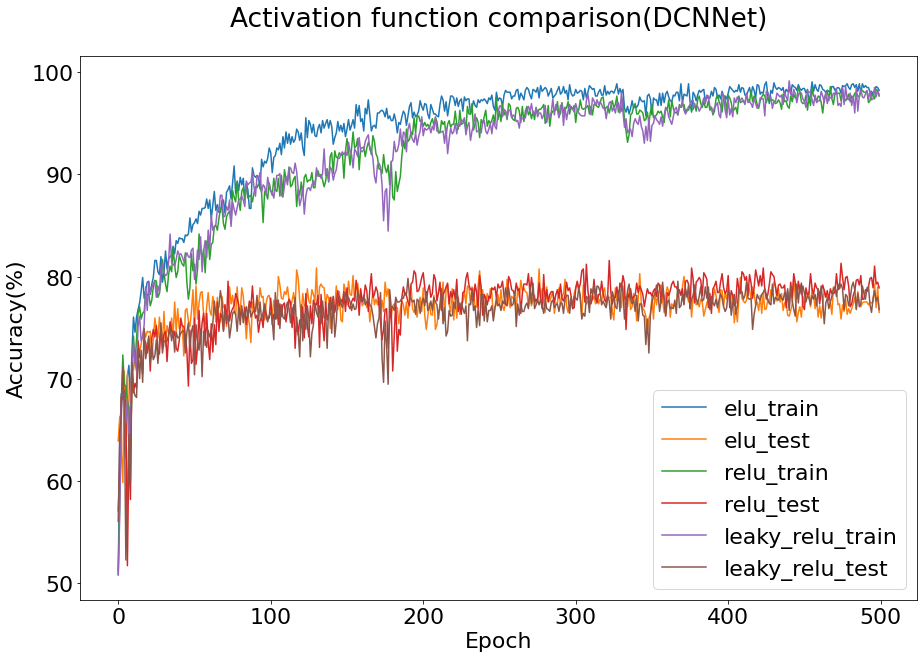

----------------------------------------------------------
The best accuracy is 86.11111111111111 and the network is EEGNet - relu


In [7]:
for net_str in range(len(net_structure)):
    all_train_pred = []
    all_test_pred = []
    net_name = net_structure[net_str]
    for act_m in range(len(act_model)):
        train_acc = []
        test_acc = []
        train_loss = []
        
        if(net_str == 0):net = EEGNet().cuda(0)
        elif(net_str == 1):net = DCNNet().cuda(0)
        else:print("train - choose net error")
            
        params = act_model[act_m]
        optimizer = optim.Adam(net.parameters())

        for epoch in range(epochs):  # loop over the dataset multiple times
            epoch_temp = epochs//3
            if(epoch < (epoch_temp)):batch_size = batch_list[0]
            elif(epoch < epoch_temp*2):batch_size = batch_list[1]
            else:batch_size = batch_list[2]
                
            running_loss = 0.0

            #train
            for i in range(int(len(X_train)/batch_size)):
                s = i*batch_size
                e = i*batch_size+batch_size

                inputs = torch.from_numpy(X_train[s:e]).float()
                labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)

                # wrap them in Variable
                inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs, params)
                train_output += outputs.T.tolist()[0]

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.data

            #test
            for i in range(int(len(X_test)/batch_size)):
                s = i*batch_size
                e = i*batch_size+batch_size

                inputs = torch.from_numpy(X_test[s:e]).float()
                labels = torch.FloatTensor(np.array([y_test[s:e]]).T*1.0)

                # wrap them in Variable
                inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))

                # forward + backward
                outputs = net(inputs, params)
                test_output += outputs.T.tolist()[0]

            #accuracy
            train_accuracy = accuracy_score(np.array(y_train), np.array(train_output).round()) 
            train_output = []
            test_accuracy = accuracy_score(np.array(y_test), np.array(test_output).round())  
            test_output = []
            train_acc.append(train_accuracy)
            test_acc.append(test_accuracy)
            train_loss.append(running_loss.tolist())
            all_train_pred.append(train_accuracy*100)
            all_test_pred.append(test_accuracy*100)
            
            temp = total_pred[0]
            if(float(temp) < test_accuracy*100):
                total_pred = [test_accuracy*100, net_name, params]
                

            if epoch == 0:
                print(net_name, "-", params, "start!")
            if (epoch != 0) & (epoch % 100 == 0):
                print(net_name, "-", params, ": ", epoch, "finished", "Max train_accuracy ", '%.4f' % (max(train_acc)*100), "%", "Max test_accuracy  ", '%.4f' % (max(test_acc)*100), "%", "batch_size ", batch_size)

        # Validation accuracy
        print("Total Epoch: ", epochs)
        print("Net: ", net_name, "-", params)
        print("Max train_accuracy ", '%.4f' % (max(train_acc)*100), "%")
        print("Max test_accuracy  ", '%.4f' % (max(test_acc)*100), "%")
        print("min train_loss     ", '%.10f' % (min(train_loss)))
        compare_plot(all_train_pred, all_test_pred, net_name)
        print("----------------------------------------------------------")
print("The best accuracy is", total_pred[0], "and the network is", total_pred[1], "-", total_pred[2])

In [8]:
net = EEGNet().cuda(0)
print(net)

EEGNet(
  (conv1): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
  (batchnorm1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
  (batchnorm2): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pooling2): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (conv3): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
  (batchnorm3): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pooling3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (fc1): Linear(in_features=736, out_features=1, bias=True)
)


In [9]:
net = DCNNet().cuda(0)
print(net)

DCNNet(
  (conv1): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
  (conv2): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
  (batchnorm1): BatchNorm2d(25, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pooling1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(50, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pooling2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
  (batchnorm3): BatchNorm2d(100, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (pooling3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(100, 200, kernel_size=(1, 5), stride=(1, 1))
  (batchnorm4): BatchNorm2d(200, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  